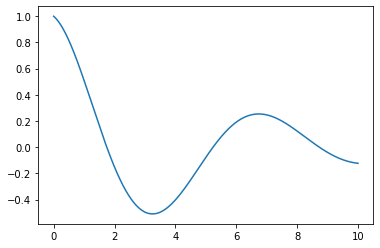

In [2]:
# Reference: https://hal.inria.fr/inria-00179732/document

import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt
from IPython.display import display

%matplotlib inline

# set up a sum of coefficients to estimate

N = 1
T = 10
alpha_real = [-0.2, -0.2]
alpha_imag = [0.9, -0.9]
times = np.linspace(0, T, 10000)
signal = sum([np.exp((alpha_real[i] + 1j * alpha_imag[i]) * times) for i in range(N)])
plt.plot(times, signal.real)

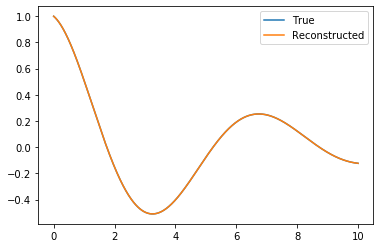

In [3]:
# set up and solve the matrix equation

def reconstruct_modes(times, signal, N, v=None):
    if v is None:
        v = N + 2
    # takes in a time axis for a signal, the signal, and the number of modes to reconstruct.
    # returns an np array of the exponential coefficients.
    fact = np.math.factorial
    A = np.zeros((N, N), dtype='complex')
    d = np.zeros(N, dtype='complex')
    assert v > N + 1, "only numerical integration allowed"

    def permute(n, k):
        # useful because it's the coefficient on the 'k'th derivative of s^n
        assert n >= k, "permute got a bad value"
        return fact(n)/fact(n - k)

    def choose(n, k):
        # useful because product rule works
        assert n >= k, "choose got a bad value"
        return fact(n)/(fact(k)*fact(n - k))

    # set up d

    for i in range(1,N+1):
        for k in range(N+2):
            to_integrate = (T - times)**(v-N+k-2) * times**(N+i-k) * signal
            integral = integrate.simps(to_integrate, times)
            d[i-1] += choose(N+i, k) * permute(N+1, k) * (-1)**(N+i-k)/fact(v-N+k-2) * integral

    # set up A
    for i in range(1,N+1):
        for j in range(1,N+1):
            for k in range(N+2-j):
                to_integrate = (T - times)**(v-N+j+k-2) * times**(N+i-k) * signal
                integral = integrate.simps(to_integrate, times)
                A[i-1][j-1] += choose(N+i, k) * permute(N+1-j, k) * (-1)**(N+i-k)/fact(v-N+j+k-2) * integral

    # d = A*theta
    theta = np.linalg.inv(A).dot(d)
    theta = np.hstack((1, -theta))
    return np.roots(theta)

alpha = reconstruct_modes(times, signal, N)
reconstructed = sum([np.exp(alpha[i] * times) for i in range(N)])
plt.plot(times, signal.real, label='True')
plt.plot(times, reconstructed.real, label='Reconstructed')
plt.legend()

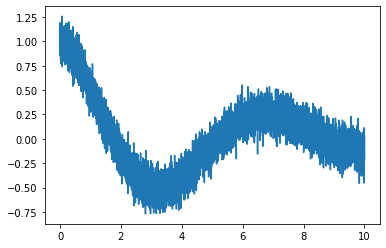

In [4]:
# now let's try adding in some noise

noise = 0.1
noisy_signal = signal + np.random.normal(0, noise, times.size)
plt.plot(times, noisy_signal.real)

[-0.2+0.9j]


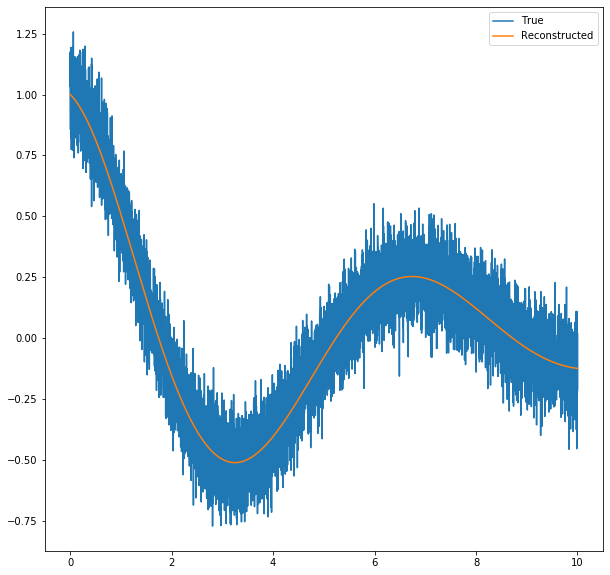

In [6]:
alpha = reconstruct_modes(times, signal, N)
print(alpha)
reconstructed = sum([np.exp(alpha[i] * times) for i in range(N)])
plt.figure(figsize=(10,10))
plt.plot(times, noisy_signal.real, label='True')
plt.plot(times, reconstructed.real, label='Reconstructed')
plt.legend()

In [10]:
# now for something a little more like the vibe modes
# let's eliminate hypotheses one by one.
# hypothesis 1: 1 second at 1 kHz is insufficient

def make_signal(f, k, T, f_sampling=1000):
    times = np.arange(0, T, 1/f_sampling)
    signal = np.exp(1j*2*np.pi*f*times)*np.exp(-2*np.pi*k*f*times)
    return times, signal

f, k, T = 100, 0.001, 1
print("expected:", -2*np.pi*f*k + 2j*np.pi*f)
reconst = reconstruct_modes(*make_signal(f, k, T, 1000),1)
print("actual:", reconst)

expected: (-0.6283185307179586+628.3185307179587j)
actual: [-521.59365921+980.27668852j]


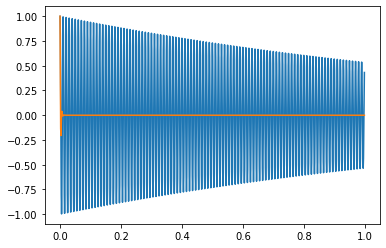

In [11]:
times, signal = make_signal(f, k, T)
plt.plot(times, signal.real)
plt.plot(times, np.exp(reconst * times).real)